In [4]:
import gcsfs
import pandas as pd
import joblib
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
from google.cloud import storage

warnings.filterwarnings("ignore")

In [2]:
import gcsfs
import joblib


def load_data_from_gcs(file_paths):
    fs = gcsfs.GCSFileSystem()

    data = {}
    for key, file_path in file_paths.items():
        with fs.open(file_path, 'rb') as f:
            data[key] = joblib.load(f)



    return data

In [9]:
import pickle

storage_client = storage.Client.create_anonymous_client()

bucket = storage_client.bucket("sepsis-prediction-mlops")
blob = bucket.blob(f"data/processed_data/X_train.pkl")
blob.download_to_filename("X_train.pkl")

blob = bucket.blob(f"data/processed_data/X_test.pkl")
blob.download_to_filename("X_test.pkl")

blob = bucket.blob(f"data/processed_data/y_train.pkl")
blob.download_to_filename("y_train.pkl")

blob = bucket.blob(f"data/processed_data/y_test.pkl")
blob.download_to_filename("y_test.pkl")


X_train = pd.read_pickle("/content/X_train.pkl")
X_test = pd.read_pickle("/content/X_test.pkl")
y_train = pd.read_pickle("/content/y_train.pkl")
y_test = pd.read_pickle("/content/y_test.pkl")


train_df= X_train.join(y_train)
test_df= X_test.join(y_test)
majority_class = train_df[train_df['SepsisLabel'] == 0]
minority_class = train_df[train_df['SepsisLabel'] == 1]

# Under Sampling

majority_class_subset = majority_class.sample(n=2*len(minority_class))
train_df = pd.concat([majority_class_subset, minority_class])
X_train = train_df.drop('SepsisLabel', axis=1)
y_train = train_df['SepsisLabel']
test_rows=int(len(train_df)*0.25)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_rows, random_state=42)
for train_index, test_index in splitter.split(test_df, test_df['SepsisLabel']):
    test_df = test_df.iloc[test_index]

X_test = test_df.drop('SepsisLabel', axis=1)
y_test = test_df['SepsisLabel']

In [44]:
def get_models_and_parameters():
    models_and_parameters = {
        'RandomForest': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(),
            'params': {
                'n_estimators': [5, 15, 200],
                'max_depth': [3, 6, 9],
                'learning_rate': [0.01, 0.1, 0.2]
            }
        },
        'DecisionTree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10]
            }
        },
        'LogisticRegression': {
            'model': LogisticRegression(max_iter=200),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['liblinear', 'lbfgs']
            }
        }
    }
    return models_and_parameters

In [63]:
models_and_parameters = get_models_and_parameters()

In [70]:
rf = models_and_parameters['RandomForest']
rf

{'model': RandomForestClassifier(),
 'params': {'n_estimators': [50, 100, 200],
  'max_depth': [None, 10, 20],
  'min_samples_split': [2, 5, 10]}}

In [71]:
from sklearn.metrics import make_scorer, recall_score
scorer = make_scorer(recall_score, average='weighted')
grid_search = GridSearchCV(estimator=rf['model'], param_grid=rf['params'], cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(recall_score, average=weighted))

{'mean_fit_time': array([0.11461864, 0.348172  , 0.1197546 , 0.34499316, 0.11955161,
       0.66362429]), 'std_fit_time': array([0.01754238, 0.01981111, 0.00213512, 0.02223147, 0.00913566,
       0.27132974]), 'mean_score_time': array([0.00613942, 0.00640612, 0.00640903, 0.00638309, 0.00603175,
       0.00847406]), 'std_score_time': array([0.00015031, 0.00040071, 0.00088185, 0.0003883 , 0.00022563,
       0.00305913]), 'param_C': masked_array(data=[0.1, 0.1, 1, 1, 10, 10],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_solver': masked_array(data=['liblinear', 'lbfgs', 'liblinear', 'lbfgs',
                   'liblinear', 'lbfgs'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.1, 'solver': 'liblinear'}, {'C': 0.1, 'solver': 'lbfgs'}, {'C': 1, 'solver': 'liblinear'}, {'C': 1, 'solver': 'lbfgs'}, {'C': 10, 'solver': 'liblinear'}, {'C'

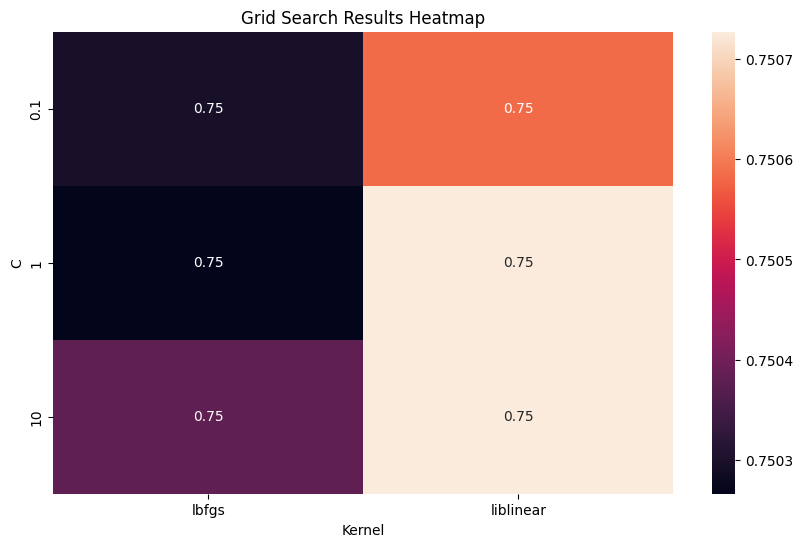

In [66]:
lr = models_and_parameters['LogisticRegression']
lr

from sklearn.metrics import make_scorer, recall_score
scorer = make_scorer(recall_score, average='weighted')

grid_search = GridSearchCV(estimator=lr['model'], param_grid=lr['params'], cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Access the grid search results
results = grid_search.cv_results_
print(results)

# Extract relevant data into a DataFrame
data = pd.DataFrame({
    'C': results['param_C'],
    'solver': results['param_solver'],
    'recall': results['mean_test_score']
})
print(data)

# Reshape the data into a pivot table format for the heatmap
heatmap_data = data.pivot(index='C', columns='solver', values='recall')

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True)
plt.xlabel('Kernel')
plt.ylabel('C')
plt.title('Grid Search Results Heatmap')
plt.show()

In [55]:
xg = models_and_parameters['XGBoost']
grid_search = GridSearchCV(estimator=xg['model'], param_grid=xg['params'], cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9], 'n_estimators': [5, 15, 200]},
             scoring=make_scorer(recall_score, average=weighted))

In [56]:
import pandas as pd

# Extract grid search results
results = pd.DataFrame(grid_search.cv_results_)

# Select relevant columns
results = results[['param_n_estimators', 'param_max_depth', 'param_learning_rate', 'mean_test_score']]
results.columns = ['n_estimators', 'max_depth', 'learning_rate', 'Recall']

In [57]:
# Pivot the DataFrame for each value of max_depth
pivot_tables = {}
for depth in results['max_depth'].unique():
    pivot_table = results[results['max_depth'] == depth].pivot(index='n_estimators', columns='learning_rate', values='Recall')
    pivot_tables[depth] = pivot_table


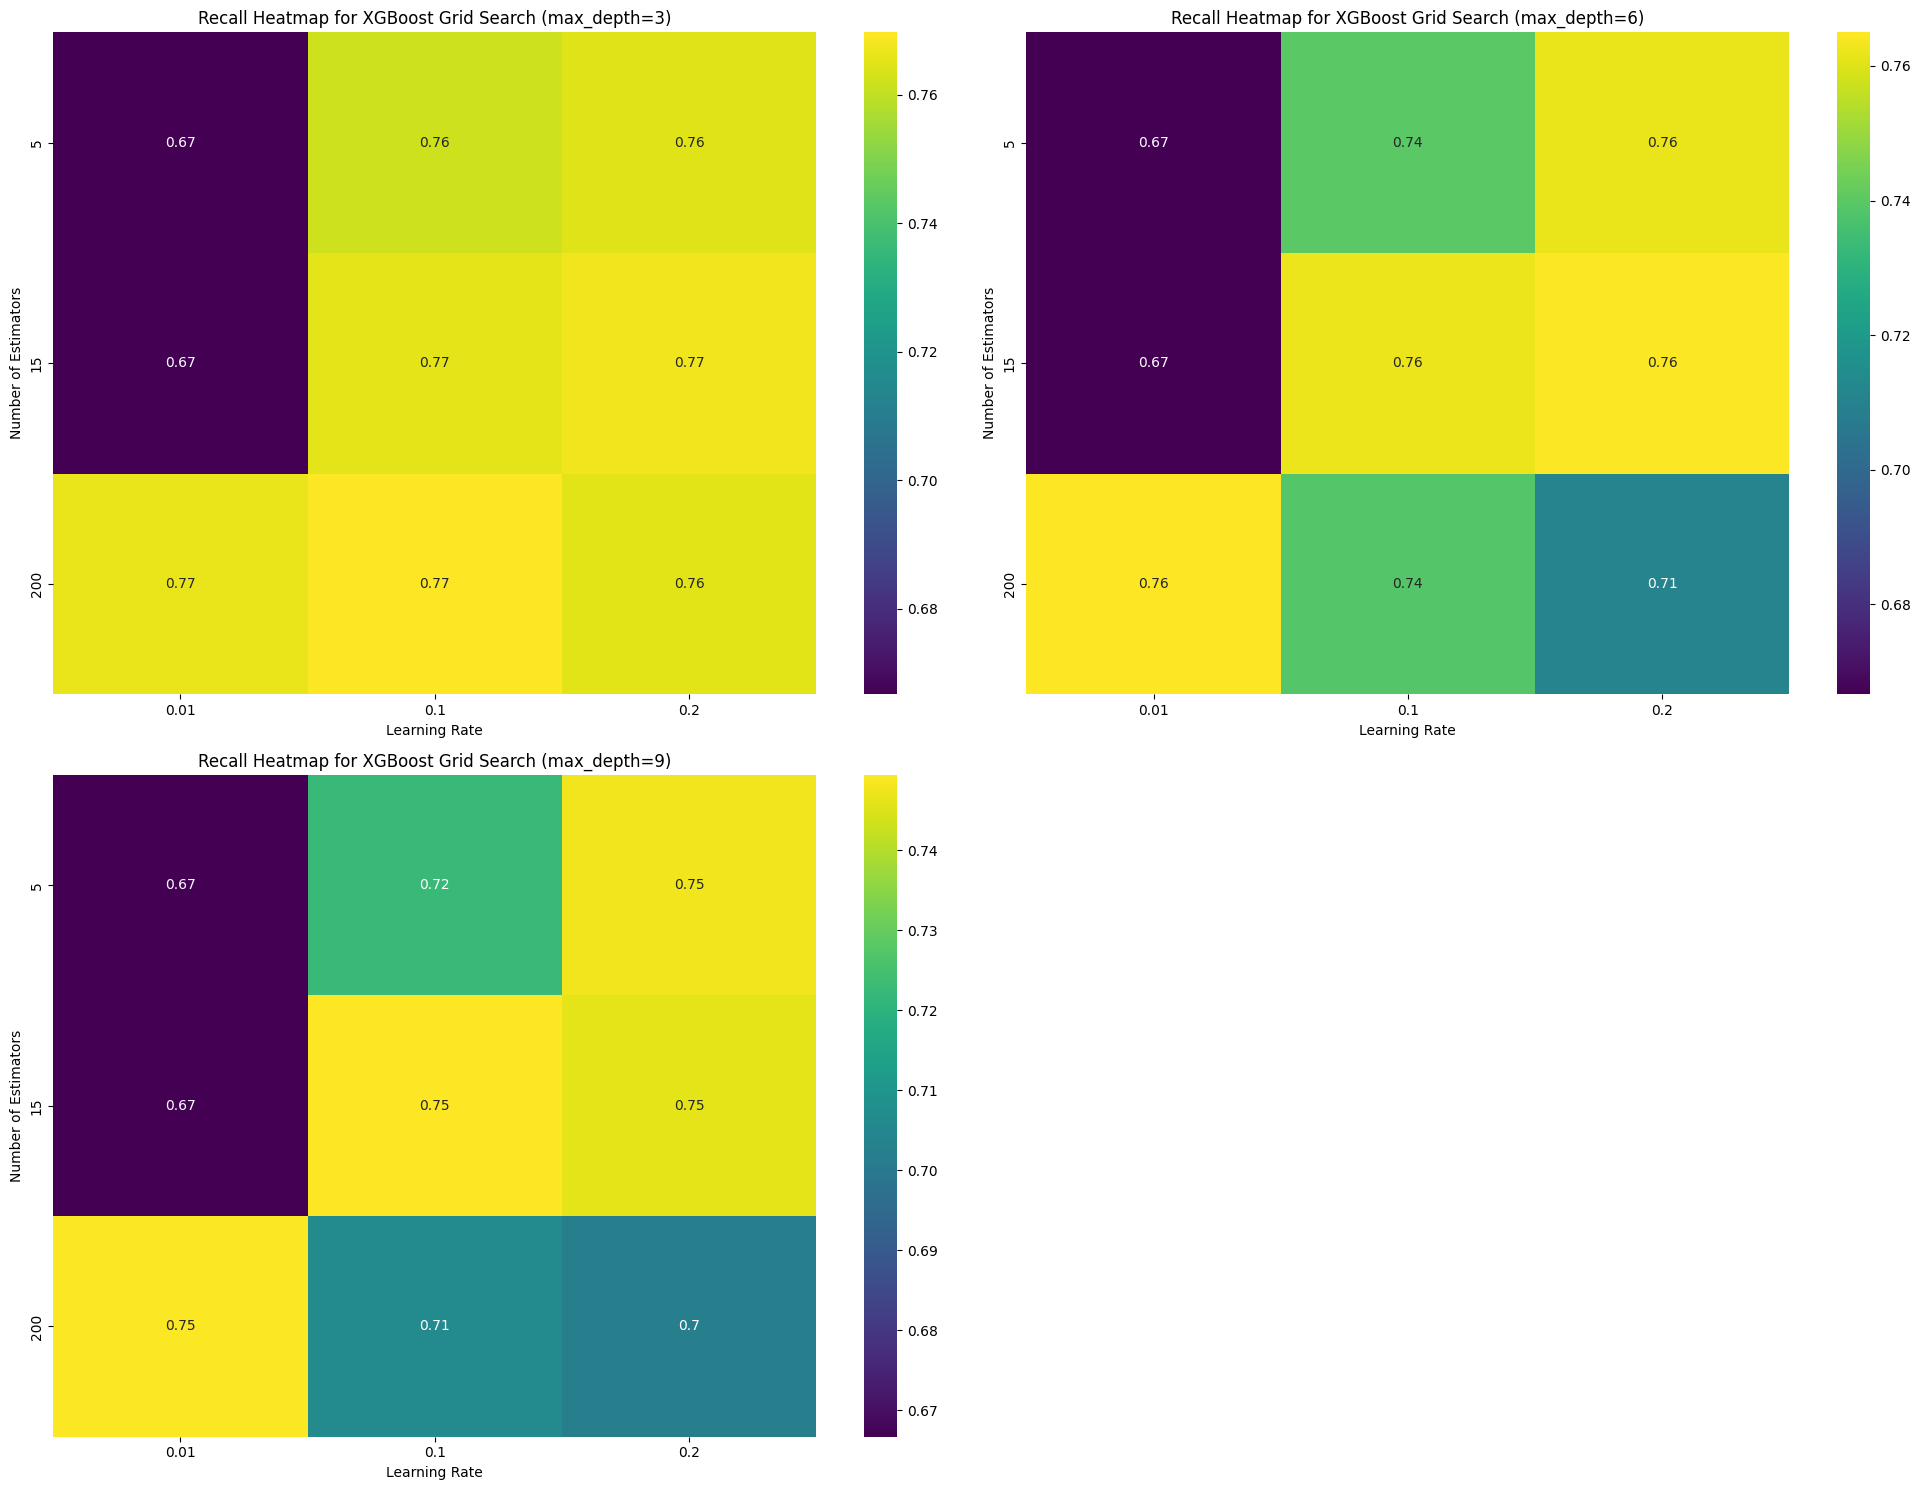

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmaps
plt.figure(figsize=(20, 15))

for i, (depth, pivot_table) in enumerate(pivot_tables.items(), 1):
    plt.subplot(2, 2, i)
    sns.heatmap(pivot_table, annot=True, cmap='viridis')
    plt.title(f'Recall Heatmap for XGBoost Grid Search (max_depth={depth})')
    plt.xlabel('Learning Rate')
    plt.ylabel('Number of Estimators')

plt.tight_layout()
plt.show()


In [59]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

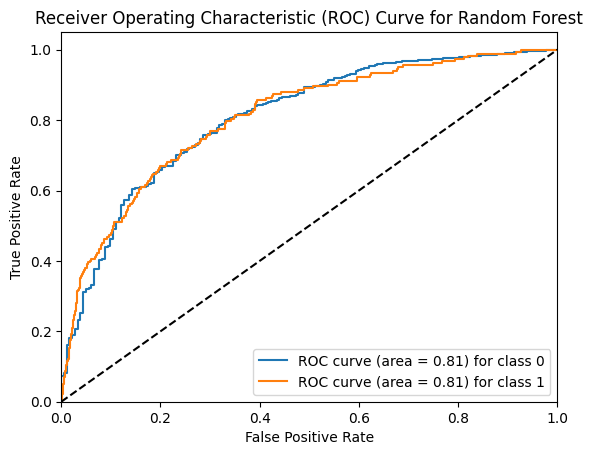

In [72]:
best_model = grid_search.best_estimator_

# Make predictions
y_pred_prob = best_model.predict_proba(X_test)

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = 2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

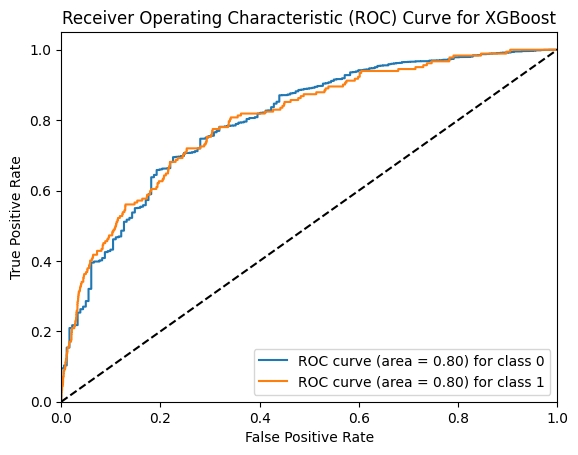

In [62]:
best_model = grid_search.best_estimator_

# Make predictions
y_pred_prob = best_model.predict_proba(X_test)

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = 2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()

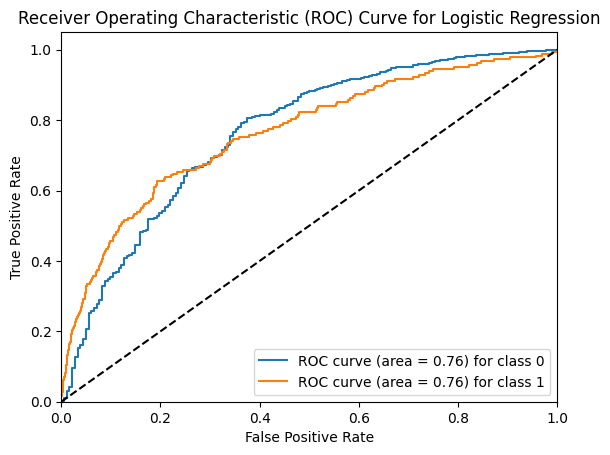

In [68]:
best_model = grid_search.best_estimator_

# Make predictions
y_pred_prob = best_model.predict_proba(X_test)

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = 2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

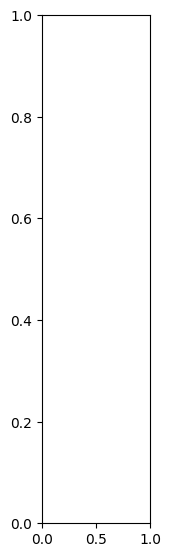

In [77]:
import shap
best_model = grid_search.best_estimator_

# Initialize the SHAP explainer
explainer = shap.Explainer(best_model)

# Calculate SHAP values
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# SHAP value plot for a single prediction
shap.plots.waterfall(shap_values[0])

In [75]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.4 MB/s eta 0:00:00


In [97]:
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.datasets import load_iris

X_train = pd.read_pickle("/content/X_train.pkl")
X_test = pd.read_pickle("/content/X_test.pkl")
y_train = pd.read_pickle("/content/y_train.pkl")
y_test = pd.read_pickle("/content/y_test.pkl")


train_df= X_train.join(y_train)
test_df= X_test.join(y_test)
majority_class = train_df[train_df['SepsisLabel'] == 0]
minority_class = train_df[train_df['SepsisLabel'] == 1]

# Under Sampling

majority_class_subset = majority_class.sample(n=2*len(minority_class))
train_df = pd.concat([majority_class_subset, minority_class])
X_train = train_df.drop('SepsisLabel', axis=1)
y_train = train_df['SepsisLabel']
test_rows=int(len(train_df)*0.25)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_rows, random_state=42)
for train_index, test_index in splitter.split(test_df, test_df['SepsisLabel']):
    test_df = test_df.iloc[test_index]

X_test = test_df.drop('SepsisLabel', axis=1)
y_test = test_df['SepsisLabel']
print(len(X_test))
print(len(y_test))
# Define model and parameters



8681
8681


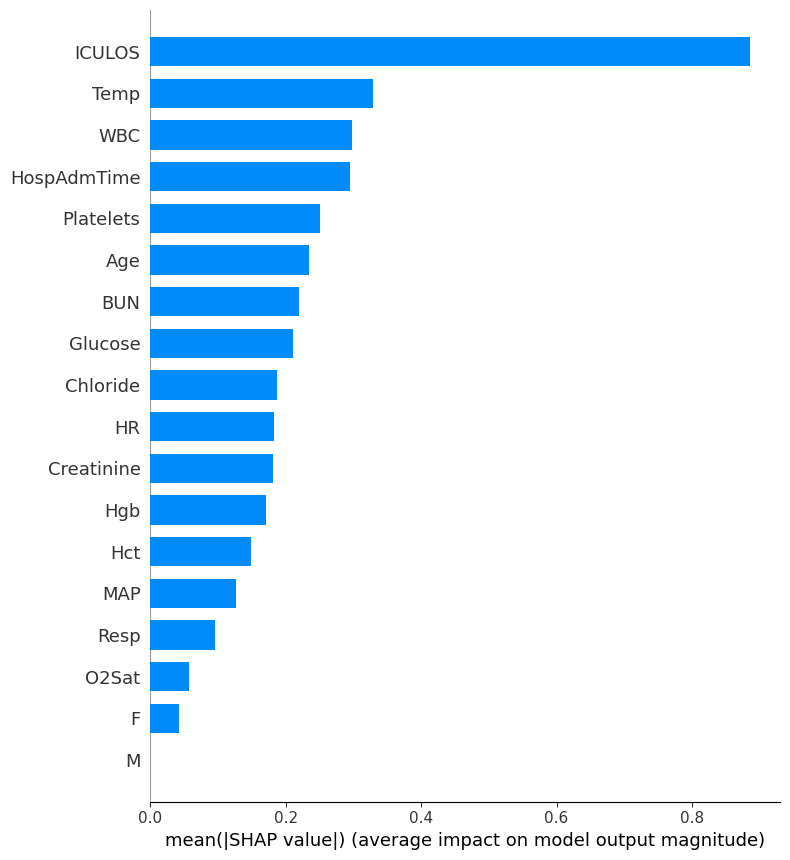

In [98]:
xgb_model = XGBClassifier(n_estimators=200,max_depth=9,learning_rate=0.1)


# Get the best model
best_model = xgb_model
best_model.fit(X_train, y_train)
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# SHAP value plot for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0,:])

In [102]:
yyy = pd.DataFrame(y_test).reset_index()
yyy[yyy["SepsisLabel"]==1]

,index,SepsisLabel
109,762,1
127,24999,1
292,84898,1
306,156656,1
405,4417,1
...,...,...
8335,122371,1
8375,73459,1
8385,30667,1
8512,28127,1


In [119]:
print("Positive Sepsis")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[8385], X_test.iloc[8385,:])

Positive Sepsis


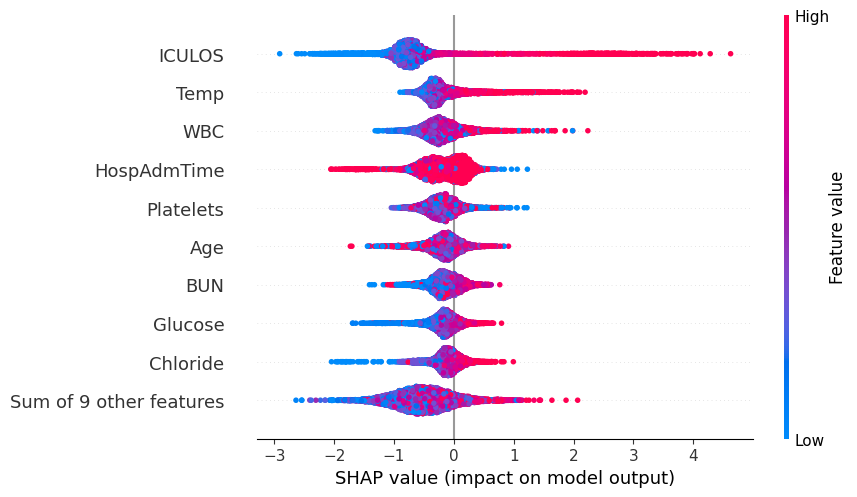

In [112]:
shap_values2 = explainer(X_test)
shap.plots.beeswarm(shap_values2)

In [120]:
print("Negative Sepsis")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[500], X_test.iloc[500,:])

Negative Sepsis


In [106]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[100], X_test.iloc[100,:])